# Gate calibration with RL with the Quantum Orchestration Platform

This notebook is the template workflow enabling you to run gate calibration leveraging all the low-level capabilities of the QOP for maximum efficiency.

In [2]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, Gate
from typing import List
from gymnasium.spaces import Box
from rl_qoc.qua import QMEnvironment, QMConfig, CustomQMPPO
from quam_libs.components import QuAM, Transmon
from qiskit_qm_provider import FluxTunableTransmonBackend, QMInstructionProperties, InputType
from qiskit_qm_provider.backend import add_basic_macros_to_machine
from rl_qoc.agent.ppo_config import (
    WandBConfig,
    PPOConfig,
    TrainingConfig,
    TrainFunctionSettings,
    TotalUpdates,
)
from rl_qoc import (
    RescaleAndClipAction,
    GateTargetConfig,
    ChannelReward,
    StateReward,
    CAFEReward,
    ExecutionConfig,
    QEnvConfig,
    BenchmarkConfig,
)

2025-06-06 18:40:00,112 - qm - INFO     - Starting session: 025eb2d0-629a-4133-9f4b-7db59fce359d
2025-06-06 18:40:00 INFO Starting session: 025eb2d0-629a-4133-9f4b-7db59fce359d


## Accessing the device

In [3]:
from iqcc_cloud_client import IQCC_Cloud
import json
import os
from pathlib import Path

# Set your quantum computer backend
path = Path.home() / "iqcc_token.json"
with open(path, "r") as f:
    iqcc_config = json.load(f)

quantum_computer_backend = "gilboa"  # for example qc_qwfix
iqcc = IQCC_Cloud(
    quantum_computer_backend=quantum_computer_backend,
    api_token=iqcc_config[quantum_computer_backend],
)
# Get the latest state and wiring files
latest_wiring = iqcc.state.get_latest("wiring")
latest_state = iqcc.state.get_latest("state")

# Get the state folder path from environment variable
quam_state_folder_path = os.environ["QUAM_STATE_PATH"]

# Save the files
with open(os.path.join(quam_state_folder_path, "wiring.json"), "w") as f:
    json.dump(latest_wiring.data, f, indent=4)

with open(os.path.join(quam_state_folder_path, "state.json"), "w") as f:
    json.dump(latest_state.data, f, indent=4)

In [4]:
machine = QuAM.load()
if not machine.active_qubits[0].macros:
    add_basic_macros_to_machine(machine)
backend = FluxTunableTransmonBackend(machine)
print(backend.target)

Target: Transmon based QuAM
Number of qubits: 6
Instructions:
	x
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	rz
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	sx
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	delay
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	reset
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	measure
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	cz
		(1, 0)
	if_else
	while_loop
	for_loop
	switch_case



/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/backend/flux_tunable_transmon_backend.py:58: UserWarning: qiskit.pulse is not available, channel mapping will not be set.
  warnings.warn("qiskit.pulse is not available, channel mapping will not be set.")


In [5]:
list(machine.active_qubits[0].macros.keys())

['x', 'rz', 'sx', 'delay', 'reset', 'measure']

In [6]:
print(backend.options)

Options(shots=1024, compiler_options=None, simulate=None, memory=False, skip_reset=False, meas_level=<MeasLevel.CLASSIFIED: 2>, meas_return=<MeasReturnType.AVERAGE: 'avg'>, timeout=60)


In [7]:
print("Available qubits: ", backend.qubit_dict)
print("Available qubit pairs: ", backend.qubit_pair_dict)

Available qubits:  {'qC1': 0, 'qC2': 1, 'qC5': 2, 'qD1': 3, 'qD2': 4, 'qD3': 5}
Available qubit pairs:  {'qC1-qC2': (1, 0)}


In [8]:
using_vpn = True
if using_vpn:
    machine.network["cloud"] = False
    machine.network["port"] = 9510
else:
    backend.qmm = iqcc

In [9]:
machine.network

{'host': '10.1.1.6', 'port': 9510, 'cloud': False, 'octave_ips': [], 'cluster_name': 'galil_gilboa', 'octave_ports': [], 'quantum_computer_backend': 'gilboa'}

## Create a custom gate to edit

We add at the Qiskit level the custom gate we want to calibrate, and we then specify the QUA macro in charge of 
implementing the parametrized pulse representation of this template parametrized gate.

In [10]:
def apply_parametrized_circuit(
    qc: QuantumCircuit, params: List[Parameter], q_reg: QuantumRegister, **kwargs
):

    try:
        physical_qubits: List[int] = kwargs["physical_qubits"]
        backend: FluxTunableTransmonBackend = kwargs["backend"]
    except KeyError:
        raise KeyError(
            "Missing one of the required keys for the parametric circuit ('backend' and 'physical_qubits'"
        )
    custom_x = Gate("x_cal", 1, params)
    qc.append(custom_x, [q_reg[0]])

    # TODO: Enter your custom parametric QUA macro here
    def qua_macro(amp):
        qubit: Transmon = backend.get_qubit(physical_qubits[0])
        qubit.xy.play("x180", amplitude_scale=amp)

    instruction_prop = QMInstructionProperties(qua_pulse_macro=qua_macro)
    if custom_x.name not in backend.target.operation_names:
        backend.target.add_instruction(custom_x, {tuple(physical_qubits): instruction_prop})
    else:
        backend.target.update_instruction_properties(
            custom_x.name, tuple(physical_qubits), instruction_prop
        )
    return qc

## Create Environment configuration

1. Create target instance: Specify which gate you want and on which qubit it should be applied
2. Choose which reward scheme you want. You can choose among three methods that are carefully implemented within the QOP: Direct Channel/State Fidelity Estimation (DFE), and Context-Aware Fidelity Estimation (CAFE)

In [11]:
from rl_qoc import StateTargetConfig

physical_qubits = (3,)
target_gate = "x"
gate_target = GateTargetConfig(physical_qubits, gate=target_gate)
state_target = StateTargetConfig(physical_qubits, "1")
reward = StateReward()

3. Decide which action space to create
4. Decide how the parameters should be passed to the QOP (Choose between Input Stream, DGX Quantum, IO variables)
5. To fix the QUA program duration, we also can pass to the configuration the number of training updates expected (it should be the same variable used when declaring the agent).
6. Set up training hyperparameters on the environment side

In [12]:
# Action space specification
param_bounds = [(-1.98, 2.0)]  # Can be any number of bounds


# Environment execution parameters
seed = 34  # Master seed to make training reproducible
batch_size = 10  # Number of actions to evaluate per policy evaluation
n_shots = 100  # Minimum number of shots per fiducial evaluation
pauli_sampling = 10  # Number of fiducials to compute for fidelity estimation (DFE only)
n_reps = 1  # Number of repetitions of the cycle circuit
num_updates = TotalUpdates(5)

input_type = InputType.IO1


def create_action_space(param_bounds):
    param_bounds = np.array(param_bounds, dtype=np.float32)
    lower_bound, upper_bound = param_bounds.T
    return Box(low=lower_bound, high=upper_bound, shape=(len(param_bounds),), dtype=np.float32)


action_space = create_action_space(param_bounds)

backend_config = QMConfig(
    parametrized_circuit=apply_parametrized_circuit,
    backend=backend,
    input_type=input_type,
    verbosity=2,
    parametrized_circuit_kwargs={"physical_qubits": physical_qubits, "backend": backend},
    num_updates=TotalUpdates.total_updates,
)
execution_config = ExecutionConfig(
    batch_size=batch_size,
    sampling_paulis=pauli_sampling,
    n_shots=n_shots,
    n_reps=n_reps,
    seed=seed,
    control_flow_enabled=True,
)
q_env_config = QEnvConfig(
    target=gate_target,
    backend_config=backend_config,
    action_space=action_space,
    execution_config=execution_config,
    reward=reward,
    benchmark_config=BenchmarkConfig(0),
)  # No benchmark for now

q_env = QMEnvironment(training_config=q_env_config)
rescaled_env = RescaleAndClipAction(q_env, -1.0, 1.0)

In [13]:
print(backend.target)

Target: Transmon based QuAM
Number of qubits: 6
Instructions:
	x
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	rz
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	sx
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	delay
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	reset
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	measure
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	cz
		(1, 0)
	if_else
	while_loop
	for_loop
	switch_case
	x_cal
		(3,):



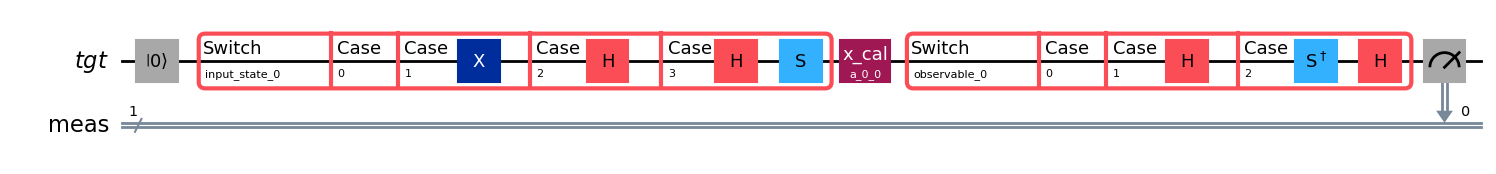

In [14]:
q_env.real_time_circuit.draw("mpl")

In [15]:
q_env.layout.get_physical_bits()

{3: <Qubit register=(1, "tgt"), index=0>}

2025-06-06 18:40:08 INFO Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit/providers/__init__.py)
2025-06-06 18:40:08 INFO Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit/providers/__init__.py)
2025-06-06 18:40:08 INFO Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit/providers/__init__.py)
2025-06-06 18:40:08 INFO Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit/providers/__init__.py)


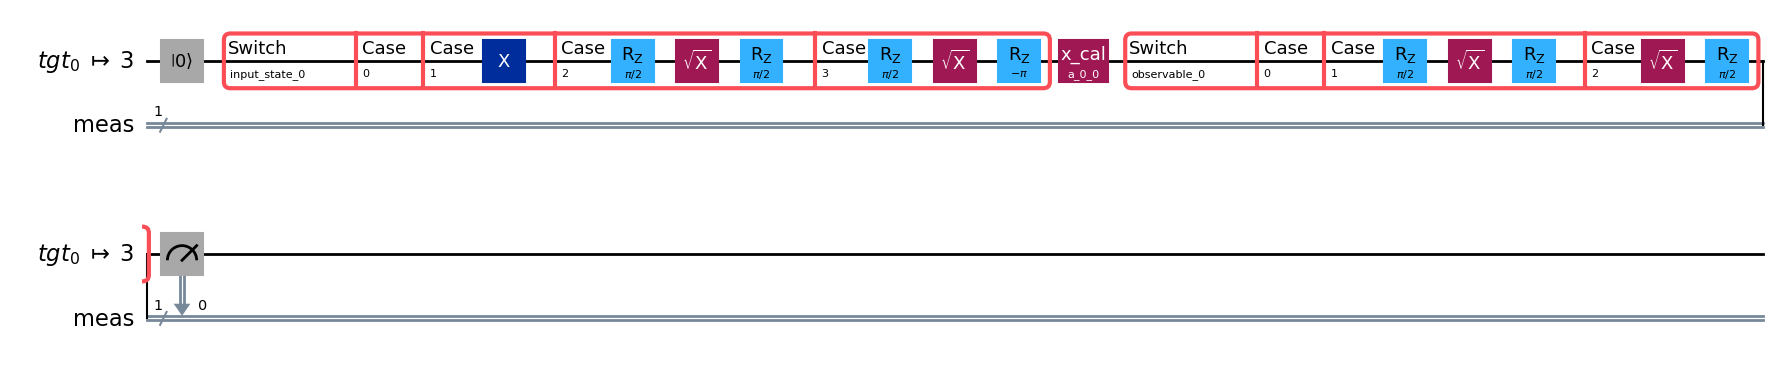

In [16]:
q_env.real_time_transpiled_circuit.draw("mpl")

In [1]:
print(backend.oq3_exporter.dumps(q_env.real_time_transpiled_circuit))

NameError: name 'backend' is not defined

In [16]:
print(backend.target)

Target: Transmon based QuAM
Number of qubits: 6
Instructions:
	x
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	rz
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	sx
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	delay
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	reset
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	measure
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	cz
		(1, 0)
	if_else
	while_loop
	for_loop
	switch_case
	x_cal
		(0,):



In [17]:
from qm import generate_qua_script

print(generate_qua_script(q_env.rl_qoc_training_qua_prog(num_updates.total_updates)))


# Single QUA script generated at 2025-06-06 16:17:07.869485
# QUA library version: 1.2.3a1

from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    v1 = declare(fixed, value=0.0)
    v2 = declare(int, value=0)
    v3 = declare(int, value=0)
    a1 = declare(fixed, value=[0.0])
    v4 = declare(int, )
    a2 = declare(fixed, value=[1.0])
    v5 = declare(int, )
    a3 = declare(int, value=[0, 0])
    v6 = declare(int, )
    v7 = declare(int, value=100)
    v8 = declare(int, )
    v9 = declare(int, )
    v10 = declare(int, value=0)
    v11 = declare(int, value=34)
    set_dc_offset("qC1.z", "single", 0.07375371431608037)
    set_dc_offset("qC2.z", "single", 0.032184737399695094)
    set_dc_offset("qC5.z", "single", 0.04219068583934504)
    set_dc_offset("qD1.z", "single", -0.00469158638120896)
    set_dc_offset("qD2.z", "single", -0.025784270666626394)
    set_dc_offset("qD3.z", "single", 0.01263323063996873)
    set_dc_offset("qA1.z", "single", 0.0)
   

In [18]:
backend.qm

2025-06-06 16:17:10,021 - qm - INFO     - Performing health check
2025-06-06 16:17:10 INFO Performing health check
2025-06-06 16:17:10,397 - qm - INFO     - Cluster healthcheck completed successfully.
2025-06-06 16:17:10 INFO Cluster healthcheck completed successfully.


/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/quam/components/channels.py:647: UserWarning: The 'thread' element argument is deprecated from qm.qua >= 1.2.2. Use 'core' instead.
  warnings.warn(


In [19]:
ppo_config = PPOConfig.from_yaml("agent_config.yaml")
ppo_agent = CustomQMPPO(ppo_config, rescaled_env)

ppo_training = TrainingConfig(num_updates)
ppo_settings = TrainFunctionSettings(plot_real_time=True, print_debug=True)

In [20]:
q_env.backend.qmm.list_open_qms()

['QM-93f7f53d-8510-4dd8-b5e8-722923307e16']

In [21]:
q_env.backend.qmm.get_jobs(status=["Running"])

[]

In [22]:
q_env.backend.qmm.get_qm(q_env.backend.qmm.list_open_qms()[0])

In [23]:
job = q_env.start_program()

2025-06-06 16:17:16,915 - qm - INFO     - Clearing queue
2025-06-06 16:17:16 INFO Clearing queue
2025-06-06 16:17:18,007 - qm - INFO     - Adding program to queue.
2025-06-06 16:17:18 INFO Adding program to queue.


In [24]:
job

JobApiWithDeprecations(connection_details=ConnectionDetails(host='10.1.1.6', port=9510, user_token='', ssl_context=None, max_message_size=104857600, headers={'x-grpc-service': 'gateway', 'cluster_name': 'galil_gilboa'}, timeout=60, debug_data=None), job_id=2636206a-f2f1-4e30-8dbb-af3906064666)

In [23]:
ppo_agent.train(ppo_training, ppo_settings)

Pushing value [0.21378739178180695] to stream mu


/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/qua/qua_ppo.py:29: RuntimeWarning: overflow encountered in scalar multiply
  return (a * seed + c) % m


Pushing value [0.5203530788421631] to stream sigma
Just pushed policy parameters to OPX: [0.21378739178180695] [0.5203530788421631]
Pushing value 4 to stream max_input_state
Pushing value 0 to stream input_state_0
Pushing value 1 to stream input_state_0
Pushing value 2 to stream input_state_0
Pushing value 3 to stream input_state_0
Fetching value from reward with input type INPUT_STREAM


TimeoutError: result reward was not done in time

In [ ]:
q_env.mean_action

In [ ]:
machine.network

In [25]:
q_env.max_input_state.push_to_opx(1, job)

In [26]:
q_env.input_state_vars.push_to_opx({"input_state_0": 1}, job)

In [19]:
q_env.policy.push_to_opx({"mu": [1.0], "sigma": [0.2]}, job, 2)

Setting mu to 1.0
Setting sigma to 0.2


In [20]:
job.is_paused()

True

In [21]:
q_env.qm_job.result_handles.reward.fetch_all()

array([([0],), ([0],)], dtype=[('value', '<i8', (1,))])

In [22]:
job.result_handles.mu.fetch_all()

array([([1.],)], dtype=[('value', '<f8', (1,))])

In [25]:
q_env.close()

Job status:  canceled


True

In [ ]:
q_env.backend.qm.get_jobs(status=["Running"])

In [35]:
q_env.reward.input_type

<InputType.IO1: 'IO1'>

In [ ]:
q_env.config.reward.get_reward_data(
    q_env.circuit,
    np.zeros((1, q_env.n_actions)),
    q_env.target,
    q_env.config,
).input_indices[0]

In [ ]:
q_env.observable_vars

In [ ]:
from qm.qua import *

with program() as qua_program:
    gate = declare_input_stream(fixed, name="gate_input_stream")

    a = declare(fixed)
    r1 = declare_stream()
    r2 = declare_stream()
    v2 = declare(
        bool,
    )
    advance_input_stream(gate)
    with while_(gate > 0):
        a = gate
        save(a, r1)
        assign(v2, (a > 0.2))
        save(v2, r2)
        advance_input_stream(gate)

    with stream_processing():
        r1.save_all("measurements")
        r2.save_all("state")

job = backend.qm.execute(qua_program)

In [ ]:
result = job.result_handles

optimization_sequence = [0.1, 0.4, 0.06]

for id, value in enumerate(optimization_sequence):
    job.push_to_input_stream("gate_input_stream", value)
    result.measurements.wait_for_values(id + 1)
    print("Full data", str(result.measurements.fetch_all()))
    print(f"{id}: Received ", str(result.measurements.fetch(id)))
    result.state.wait_for_values(id + 1)
    print(f"{id}: Received ", str(result.state.fetch(id)))
    print("Full data", str(result.state.fetch_all()))

# finish QUA program
job.push_to_input_stream("gate_input_stream", 0)